### Getting Data from PostgreSQL DB

Prior to this we have successfull obtained our dataset from Kaggle and migrated it from a `sqlite` database to a `PostgreSQL` database. Now we can query from it using the `psycopg2` package.

#### Required Packages

In [2]:
import pandas as pd       # Data manipulation
import psycopg2           # Query against psql dbs
import numpy as np        # math and arrays
import matplotlib.pyplot as plt # plotting
from scipy import stats   # stats
import seaborn as sns     # prettier plotting

#### Create Connection

We stored out data in a `PostgreSQL` database named `soccer`.

In [3]:
conn = psycopg2.connect("dbname=soccer")

---

### Set up queries

We will write queries for each of our proposed hypothesis tests.

#### 3) Impact of height on heading accuracy.

We notice that the `player_attribute` table includes new attributes at regular intervals. For simplicity we will just take the average of the ratings.

In [4]:
query_3= """
    select
        p.player_name
        ,p.height
        ,avg(pa.heading_accuracy) as heading_accur_avg
    from
        player p
        inner join player_attributes pa on p.player_api_id = pa.player_api_id
    group by
        1,2
    ;
"""

---

### Run queries, put contents into pandas DataFrame

In [5]:
cur = conn.cursor()
cur.execute(query_3)

In [6]:
soccer = pd.DataFrame(cur.fetchall())
soccer.columns = [desc[0] for desc in cur.description]

In [7]:
soccer.head(10).T

,0,1,2,3,4,5,6,7,8,9
player_name,"Dario Simic,25",Claude Makelele,Cedric,Arvydas Novikovas,Koen van de Laak,Mike Frantz,Jesper Joergensen,Ryan Conroy,Jaime,Sebastian Eguren
height,180.34,175.26,167.64,177.8,182.88,182.88,182.88,177.8,187.96,185.42
heading_accur_avg,76.0000000000000000,51.8571428571428571,41.3461538461538462,44.7272727272727273,64.7777777777777778,58.6060606060606061,51.8750000000000000,56.0000000000000000,26.1724137931034483,72.5263157894736842


### EDA and additional data cleaning

In [8]:
soccer.describe()

,player_name,height,heading_accur_avg
count,11031,11031,11031
unique,10848,20,5475
top,Paulinho,182.88,52.0000000000000000
freq,5,1947,86


In [9]:
soccer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11031 entries, 0 to 11030
Data columns (total 3 columns):
player_name          11031 non-null object
height               11031 non-null object
heading_accur_avg    11031 non-null object
dtypes: object(3)
memory usage: 258.6+ KB


In [10]:
soccer['height'] = soccer['height'].astype('float')

In [11]:
soccer['heading_accur_avg'] = soccer['heading_accur_avg'].astype('float')

In [12]:
soccer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11031 entries, 0 to 11030
Data columns (total 3 columns):
player_name          11031 non-null object
height               11031 non-null float64
heading_accur_avg    11031 non-null float64
dtypes: float64(2), object(1)
memory usage: 258.6+ KB


Now would be a good time to revisit our initial hypothesis.

**Null:** There is no statistical difference in heading accuracy between Players 6 feet tall and above, and those below.  

**Alternative:** Players 6 feet tall and above and those shorter have a statistically signficant difference in their heading accuracy.  

This will be a **two-tail** test, and we will use **alpha = 0.05**


We need a conversion for centimeters to feet:  
The conversion is `1 cm` for `0.0328084 ft` 

In [13]:
INCHES_PER_CM = .0328084

In [14]:
soccer['height_in_ft'] = soccer['height'] * INCHES_PER_CM

In [15]:
# Let's check
soccer['height_in_ft'].head(10)

0    5.916667
1    5.750000
2    5.500000
3    5.833334
4    6.000000
5    6.000000
6    6.000000
7    5.833334
8    6.166667
9    6.083334
Name: height_in_ft, dtype: float64

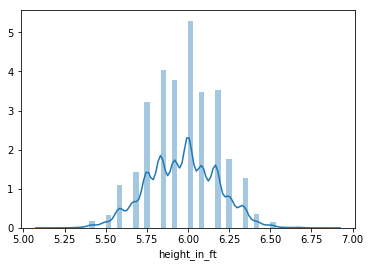

In [16]:
sns.distplot(soccer['height_in_ft'])

In [17]:
tall = soccer[soccer.height_in_ft>=6]

In [18]:
tall.head()

,player_name,height,heading_accur_avg,height_in_ft
4,Koen van de Laak,182.88,64.777778,6.000000
5,Mike Frantz,182.88,58.606061,6.000000
6,Jesper Joergensen,182.88,51.875000,6.000000
8,Jaime,187.96,26.172414,6.166667
9,Sebastian Eguren,185.42,72.526316,6.083334


In [19]:
short = soccer[soccer.height_in_ft<6]

In [20]:
short.head()

,player_name,height,heading_accur_avg,height_in_ft
0,"Dario Simic,25",180.34,76.000000,5.916667
1,Claude Makelele,175.26,51.857143,5.750000
2,Cedric,167.64,41.346154,5.500000
3,Arvydas Novikovas,177.80,44.727273,5.833334
7,Ryan Conroy,177.80,56.000000,5.833334


In [21]:
soccer.shape[0]


11031

In [22]:
tall.shape[0] + short.shape[0]

11031

In [23]:
print("# rows in 'tall':" + str(tall.shape[0]))
print("# rows in 'short':" + str(short.shape[0]))

# rows in 'tall':5851
# rows in 'short':5180


### Perform sampling

In [24]:
# Intialize counts
sample_size = 500
samples = 100

In [25]:
# Initialize lists to store average heading accuracies
means_tall = []
means_short = []

# set seed 
np.random.seed(1999)

# get samples and store average heading accuracies in list
for _ in range(samples):
    sample_tall = np.random.choice(tall['heading_accur_avg'], 
                       size=sample_size)
    means_tall.append(np.mean(sample_tall))
    
    sample_short = np.random.choice(short['heading_accur_avg'], 
                       size=sample_size)
    means_short.append(np.mean(sample_short))
     

In [26]:
print(means_tall[:10])
print(means_short[:10])


[56.83607022751281, 57.14871316997122, 58.497358741359335, 58.241687815072495, 58.60240652406622, 58.364574240611084, 58.317748701203975, 56.18953550707995, 56.45563493086505, 58.16043878566506]
[54.49488000436459, 54.73637419132682, 54.19893339131413, 54.149148713534295, 53.04909331224618, 53.55558598013215, 53.898263809253294, 54.92895464693389, 54.304236238142146, 54.659418344136135]


Let's visualize!

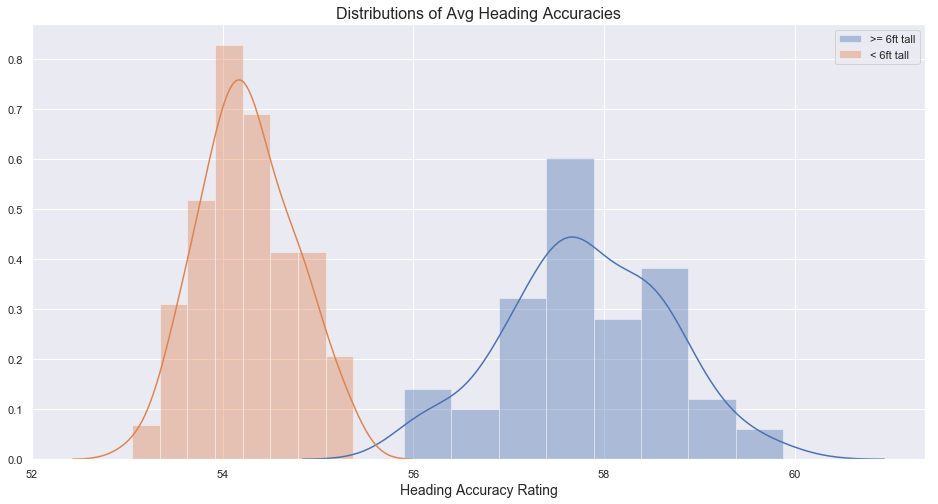

In [27]:
sns.set(rc={'figure.figsize':(16,8)})
sns.distplot(means_tall, label='>= 6ft tall')
sns.distplot(means_short, label = '< 6ft tall')
plt.legend()
plt.title("Distributions of Avg Heading Accuracies", fontsize = 16)
plt.xlabel("Heading Accuracy Rating", fontsize = 14)
plt.show()

### Perform two-sample t-test

In [28]:
t_stat, p_value = stats.ttest_ind(means_tall, means_short)

In [29]:
print('The calculated t-statistic is {}'.format( round(t_stat, 2) ))
print('The calculated p-value is {}'.format( round(p_value, 90) ))

The calculated t-statistic is 36.55
The calculated p-value is 5.999999999999998e-90


Wow. Since the p-value is virtually 0, we reject the null hypothesis at alpha = 0.05. Therefore, there appears to be a statistically significant relationship between `height` and `heading accuracy`.